In [1]:
import sqlite3
import pandas as pd
from fuzzywuzzy import process
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Establish connection to database 

In [2]:
db = sqlite3.connect('moviesrecommender1.db')

### Creation of tables

In [3]:
tables = """
CREATE TABLE IF NOT EXISTS movies (
    movieid INTEGER ,
    title TEXT NOT NULL,
    genres VARCHAR(32)
    
);

CREATE TABLE IF NOT EXISTS ratings (
    userId INTEGER,
    movieId INTEGER,
    rating INTEGER,
    timestamp INTEGER
);

CREATE TABLE IF NOT EXISTS links (
    movieid INTEGER,
    imdbid INTEGER,
    tmdbid INTEGER
);

CREATE TABLE IF NOT EXISTS tags (
    userId INTEGER,
    movieId INTEGER,
    tag TEXT,
    timestamp INTEGER
);
"""
db.executescript(tables)

### Load data from csv files into pandas dataframe

The csv files consists of
* Movies
* Ratings
* Tags
* Links

### Append dataframes to the tables created in database

In [4]:
tables = ['movies','ratings','links','tags']
for i in tables:
    fn = "data/"+i+".csv"
    
    pd.read_csv(fn).to_sql('{}'.format(i),con = db,
                        if_exists='append', index=False)

### Select the desired the columns from database tables

In [5]:
dataframe = pd.read_sql("""SELECT 
  ratings.userId,
  ratings.movieId,
  ratings.rating,
  ratings.timestamp,
  movies.title,
  movies.genres,
  tags.tag,
  links.imdbId,
  links.tmdbId
    
    
FROM ratings 
INNER JOIN movies
ON ratings.movieId = movies.movieId
LEFT JOIN tags
ON ratings.movieId= tags.movieID AND ratings.userId = tags.userId
INNER JOIN links
ON ratings.movieId = links.movieId

""", db)

### Inspect the created dataframe

In [6]:
dataframe.shape

(102677, 9)

### Building a recommender system based on user rating

In [7]:
df = dataframe.pivot_table(values = 'rating',index= 'userId', columns='title',aggfunc='first' )

In [8]:
df1 = dataframe.pivot_table(values = 'rating',index= 'userId', columns='title',aggfunc='first' ).fillna(3)

In [9]:
df1.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


### Movies to select based on user search word using fuzzywuzzy filtering

* Enter the search word for movies

In [10]:
def movieresult():
    movie1_searchword = input()
    a = process.extract(movie1_searchword, df.columns)
    list2 = [x[0] for x in a]
    return list2
   

In [11]:
movies_suggestion1 = movieresult()
movies_suggestion2 = movieresult()
movies_suggestion3 = movieresult()

hello
boy
girl


### List of suggested movies

In [12]:
from pprint import pprint
pprint(movies_suggestion1)
pprint(movies_suggestion2)
pprint(movies_suggestion3)


['Hello Again (1987)',
 'Hello Ladies: The Movie (2014)',
 'Hello, Dolly! (1969)',
 'Oh, Hello: On Broadway (2017)',
 'Othello (1995)']
['About a Boy (2002)',
 'Baby Boy (2001)',
 'Bad Boy Bubby (1993)',
 'Bad Boys (1995)',
 'Bad Boys II (2003)']
['100 Girls (2000)',
 '4 Little Girls (1997)',
 'All the Real Girls (2003)',
 'Bad Girls (1994)',
 'Beautiful Girls (1996)']


### List of selected movies

In [13]:
movies_to_rate = [movies_suggestion1[0],movies_suggestion2[2],movies_suggestion3[4]]
movies_to_rate 


['Hello Again (1987)', 'Bad Boy Bubby (1993)', 'Beautiful Girls (1996)']

### Rate the selected movies

In [14]:
def rating(i):
    Enter_rating = input()
    return int(Enter_rating)

In [15]:
rating_first = rating(movies_suggestion1[0])
rating_two = rating(movies_suggestion2[2])
rating_three = rating(movies_suggestion3[4])

2
3
4


In [16]:
movies_rating = [rating_first,rating_two,rating_three]
movies_rating

[2, 3, 4]

In [17]:
new = list(zip(movies_to_rate,movies_rating))
new

[('Hello Again (1987)', 2),
 ('Bad Boy Bubby (1993)', 3),
 ('Beautiful Girls (1996)', 4)]

### Dataframe for entering user ratings into dataframe

In [18]:
user_rating = pd.DataFrame(np.zeros(shape=(1,len(df.columns))),columns=df.columns)

In [19]:
for a,b in new:
    for i in user_rating:
        user_rating[a]= user_rating[a].replace(0,b)

In [20]:
user_rating1 = user_rating.replace(0,3)
user_rating2 = user_rating.replace(0,np.nan)

### Building NMF model

In [21]:
nmf = NMF(n_components=3)
nmf.fit(df1)
hidden_profile = nmf.transform(user_rating1)

### Reconstruct ratings for all movies

In [22]:
nmf.components_.shape

(3, 9719)

In [23]:
ypred = np.dot(hidden_profile, nmf.components_)
ypred

array([[2.994971  , 3.00042229, 3.00136669, ..., 3.00860644, 3.00025357,
        2.99732409]])

### Output the best ranking movies that user hasnt rated yet

In [24]:
recom = pd.DataFrame(ypred.T, index=df1.columns)

In [25]:
recom['profile'] = user_rating2.T
recom[recom['profile'].isna()].sort_values(by=0, ascending=False)[:5]

,0,profile
title,,
"Shawshank Redemption, The (1994)",3.521763,NaN
Forrest Gump (1994),3.427080,NaN
"Silence of the Lambs, The (1991)",3.286072,NaN
Pulp Fiction (1994),3.285229,NaN
Braveheart (1995),3.252565,NaN


### Clustering movies based on genres

In [26]:
genres = list(dataframe['genres'])
len(genres)

102677

In [27]:
genres_split = []
for g in genres:
    sublist = g.split('|')
    genres_split.append(sublist)

In [28]:
genres_split[:5]

[['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'],
 ['Comedy', 'Romance'],
 ['Action', 'Crime', 'Thriller'],
 ['Mystery', 'Thriller'],
 ['Crime', 'Mystery', 'Thriller']]

In [29]:
list_genre = [' '.join(x) for x in genres_split]
len(list_genre)

102677

### Sparse matrix for genres column

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(list_genre)
index = list(sorted(count_vectorizer.vocabulary_.keys()))
index[:5]

['action', 'adventure', 'animation', 'children', 'comedy']

In [31]:
df_Total = pd.DataFrame(count_train.todense(), columns = index)
df_Total.shape

(102677, 24)

In [32]:
data_cluster = pd.concat([dataframe['title'], df_Total], axis = 1)

In [33]:
data_cluster.head(2)

,title,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
0,Toy Story (1995),0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [34]:
data_cluster.drop('title', axis=1,inplace=True)

In [35]:
train=data_cluster.sample(frac=0.8,random_state=200)
test=data_cluster.drop(train.index)

In [36]:
train.shape, test.shape

((82142, 24), (20535, 24))

In [37]:
model = KMeans(n_clusters=3)
model.fit(test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
labels = model.predict(test)

labels[:10]

array([1, 1, 2, 0, 1, 1, 0, 2, 2, 2])

### Evaluating Cluster

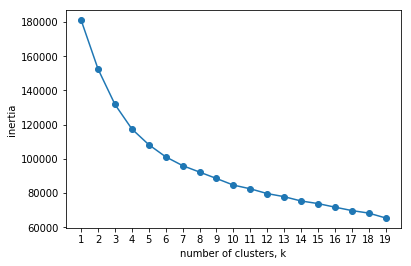

In [41]:
ks = range(1, 20)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(train)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Conclusion

As it is oberved that inertia starts becoming constant with increasing number of clusters so the best practice
will be to make cluster about 15 clusters